# Comparison of optical measurements 
- Compare methods used by AM and JW to measure various optical parameters of our specimen's ommatidia. 
- **NOTE**: The lens was damaged in six ommatidia of the **right eye** of specimen 1: C4, D4, D6, D7, E5, E7 (n=23). AM replaced measurements of thickness, curvature, lens, diameter, cone length and width from corresponding ommatidia in specimen 2. JP excluded these lenses for his measurements in the right eye. All the lenses in the left eye remain intact.
- Jing Peng measured radius of curvature for each intact lens (both left and right eyes) by fitting circles on a prob map from Ilastik px classification (210615), simulations show that this method is highly dependent on local image quality. On 210723, we try a more simple approach using least squares.
- JP excluded lens calculations for ommatidia C6 in addition to the 6 excluded by AM
- JP also used the minimum distance between the lens and distal rhabdom to compute the length of the crystallin cone. 

In [1]:
import math
import numpy as np
from typing import List
import os.path
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import statsmodels.api as sm

from cx_analysis.utils import index_by_om, yymmdd_today
from cx_analysis.dataframe_tools import assemble_cxvectors
from cx_analysis.vis.fig_tools import linear_cmap, subtype_cm
from cx_analysis.vis.hex_lattice import hexplot_TEST, hexplot

In [2]:
plt.rcdefaults()
plt.style.use('cx_analysis/vis/lamina.mplstyle') # may not work if installed as a module
### SAVE FIGS? ###
save_figs = True
fig_path = f'/mnt/home/nchua/Dropbox/lamina_figures/{yymmdd_today()}/{yymmdd_today()}'
##################
# if save_figs:
#     fig.savefig(fig_path + 'FNAME.svg')
#     fig.savefig(fig_path + 'FNAME.png')

In [14]:
tp = '210615'
data_path = f'~/Data/{tp}_lamina/'
ommatidia = list(left_om_labels)  # all 29

## Anastasia's measurements
- Optical parameters of lenses in the left eye were measured manually by AM and is located in 'data for ligh prop.xlsx'
- Rhabdomere lengths were computed from AM's microvilli orientation measurements (which lists location of the distal and proximal rhabdom boundaries). 

In [15]:
am_df = pd.read_excel(data_path + 'optics/1911_anastasia_om_measurements.xlsx', index_col=0)
am_df = am_df.iloc[1:-2] # remove last two lines of excel file
#display(am_df)
# Add pre-computed rhabdom lengths (from rhabdomere_lengths.ipynb)
rh_len = pd.read_pickle(data_path + 'optics/201123_rh_len_df.pickle')

for i, v in rh_len.iterrows():
    am_df.loc[i, 'rhabdom_len'] = float(v)
#display(am_df.head())

## NC's measurements of crystalline cone length in the left eye
- AM did not do measurements on the left eye, so NC did a similar manual process to measure CC length in those om

In [16]:
left_cc_len = pd.read_excel(data_path + 'optics/210628_lefteye_crystallinecone.xlsx', 
                      index_col='Ommatidium', nrows=29).loc[:, 'CC length (2 sig)']
left_cc_len = left_cc_len.rename('Left CC length')
#display(nc_df)

In [17]:
# Load Jing Peng's measurements for lens interal/external center coords and curvature
# Lens curvature estimates from 210521
with open(os.path.expanduser(data_path + 'optics/210723_jp_optics_measurements.json')) as fh:
    jp_data = json.load(fh)
jp_df = pd.DataFrame(jp_data)

# Convert JP's radii of curvature / distances from nm to microns
#jp_df[['radii_in', 'radii_out', 'distances']] = jp_df[['radii_in', 'radii_out', 'distances']] / 1000.0
jp_df[['radii_in', 'radii_out']] = jp_df[['radii_in', 'radii_out']] / 1000.0
# Compute lens thickness with internal/external center coordinates
dist = lambda p1, p2: np.linalg.norm(p1 - p2)
lens_thickness = [] 
for p1, p2 in zip(jp_df['centers_in'], jp_df['centers_out']):
    lens_thickness.append(dist(np.array(p1), np.array(p2)) / 1000.0)  # nm -> um
jp_df['lens_thickness'] = lens_thickness

#display(jp_df)

In [18]:
### Map indices in JP data to our ommatidia retinotopic coordinates

In [19]:
### RIGHT EYE ###
right_om_labels = {'A0': 73, 'B0': 72, 
                  'A1': 71, 'B1': 70, 'C1': 69, 
                  'A2': 68, 'B2': 67, 'C2': 66, 'D2': 65, 
                  'A3': 64, 'B3': 63, 'C3': 61, 'D3': 62, 
                  'A4': 60, 'B4': 57, 'E4': 59,  
                  'A5': 56, 'B5': 55, 'C5': 54, 'D5': 53,
                  'B6': 52, 'E6': 51}
# Make sure indices are unique for each om
assert(len(right_om_labels.keys()) == len(set(right_om_labels.values())))

right_inverted = {str(v): k for k, v in right_om_labels.items()}
right_indices = [str(v) for k, v in right_om_labels.items()]
jp_right = jp_df.loc[right_indices]
jp_right = jp_right.rename(index=right_inverted)


# Re-order Anastasia's data to match JP's right eye measurements
# Remove c6 (excluded in JP's measurements)
am_right = am_df.loc[jp_right.index]
display(am_right)

,lense diameter (stack),lense thickness,outer curvature,inner curvature,cone length (from the tip),cone width (under the lense tip),D rhabdom dist.,D rhabdom prox.,Mean Microv. Ang. Turn,rhabdom_len
A0,7.77281,3.53208,4.104361,2.970097,4.68667,6.591135,2.696265,1.842225,39.361728,18.248
B0,7.12646,3.34552,4.456473,3.036677,5.05071,6.531270,2.519815,2.331355,33.445679,17.064
A1,8.12567,3.21167,4.539853,2.936824,4.55839,6.733375,3.037035,2.222835,35.627500,15.992
B1,7.53576,3.53662,4.468678,2.695994,4.73075,6.444430,2.565815,2.166340,35.449383,17.392
C1,6.65025,3.01659,4.658214,3.342436,5.12575,6.434415,2.573990,2.266340,39.908642,15.584
A2,8.99115,3.01860,4.731129,2.876839,4.98910,7.011330,2.977810,2.396460,24.907407,14.496
B2,7.86371,2.80015,5.082763,2.545102,4.74370,6.806415,3.097335,2.450055,26.407407,15.184
C2,7.20151,3.32981,4.959154,4.029119,4.34388,6.741675,2.837255,2.292015,42.777922,15.680
D2,7.33428,2.86169,5.445023,3.446124,3.75099,6.633140,2.968950,2.206545,31.427160,13.760
A3,9.24715,3.40740,4.989014,3.011264,4.67152,6.788840,2.236840,2.301690,26.228395,12.968


In [20]:
### LEFT EYE ###
left_om_labels = {'A0': 12, 'B0': 19, 
             'A1': 11, 'B1': 21, 'C1': 26,
             'A2': 7, 'B2': 17, 'C2': 24, 'D2': 28, 
             'A3': 4, 'B3': 15, 'C3': 23, 'D3': 29, 
             'A4': 2, 'B4': 10, 'C4': 18, 'D4': 25, 'E4': 27, 
             'A5': 1, 'B5': 6, 'C5': 14, 'D5': 20, 'E5': 22, 
             'B6': 3, 'C6': 9, 'D6': 13, 'E6': 16, 
             'D7': 5, 'E7': 8}
# Make sure indices are unique for each om
assert(len(left_om_labels.keys()) == len(set(left_om_labels.values())))

left_inverted = {str(v): k for k, v in left_om_labels.items()}
left_indices = [str(v) for k, v in left_om_labels.items()]
jp_left = jp_df.loc[left_indices]
jp_left = jp_left.rename(index=left_inverted)

cc_left = left_cc_len.loc[jp_left.index]

In [21]:
dra_c = '#434371'
ndra_c = '#C64191'
dra_m = '^'
ndra_m = 'v'

dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
ndra_om = [o for o in ommatidia if o not in dra_om]
assert(len(dra_om) + len(ndra_om) == 29)

def om_colors(om_list: List, dra_om: List=dra_om, as_rgb: bool=False, 
              dra_c: str=dra_c, ndra_c: str=ndra_c) -> List:
    
    c_list = []
    for o in om_list:
        if str(o) in dra_om:
            c_list.append(dra_c)
        else:
            c_list.append(ndra_c)
    if as_rgb:
        return [tuple(int(h.lstrip('#')[i:i+2], 16)/255.0 for i in (0, 2, 4)) for h in c_list] 
    else:
        return c_list
    
def om_markers(om_list: List, dra_om: List=dra_om, 
               dra_m: str=dra_m, ndra_m: str=ndra_m) -> List:
    
    m_list = []
    for o in om_list:
        if o in dra_om:
            m_list.append(dra_m)
        else:
            m_list.append(ndra_m)
            
    return m_list

## LEFT VS RIGHT Crystalline cone length

In [22]:
## FOR LEFT RIGHT COMPARISONS, GET RID OF OMMATIDIA EXCLUDED IN RIGHT EYE
left_cc_len_in_r = left_cc_len.loc[am_right.index]

Left variance: 1.8945541022592154
Right variance: 0.5955458331049587


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     cone length (from the tip)   R-squared:                       0.730
Model:                                    OLS   Adj. R-squared:                  0.716
Method:                         Least Squares   F-statistic:                     54.04
Date:                        Fri, 23 Jul 2021   Prob (F-statistic):           4.20e-07
Time:                                18:13:03   Log-Likelihood:                -11.118
No. Observations:                          22   AIC:                             26.24
Df Residuals:                              20   BIC:                             28.42
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.7003      0.336      5.060      0.000       0.999       2.401
Left CC length     0.5002      0.068      7.351      0.000       0.358       0.642
==============================================================================
Omnibus:                        4.963   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                3.098
Skew:                          -0.879   Prob(JB):                        0.213
Kurtosis:                       3.536   Cond. No.                         19.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

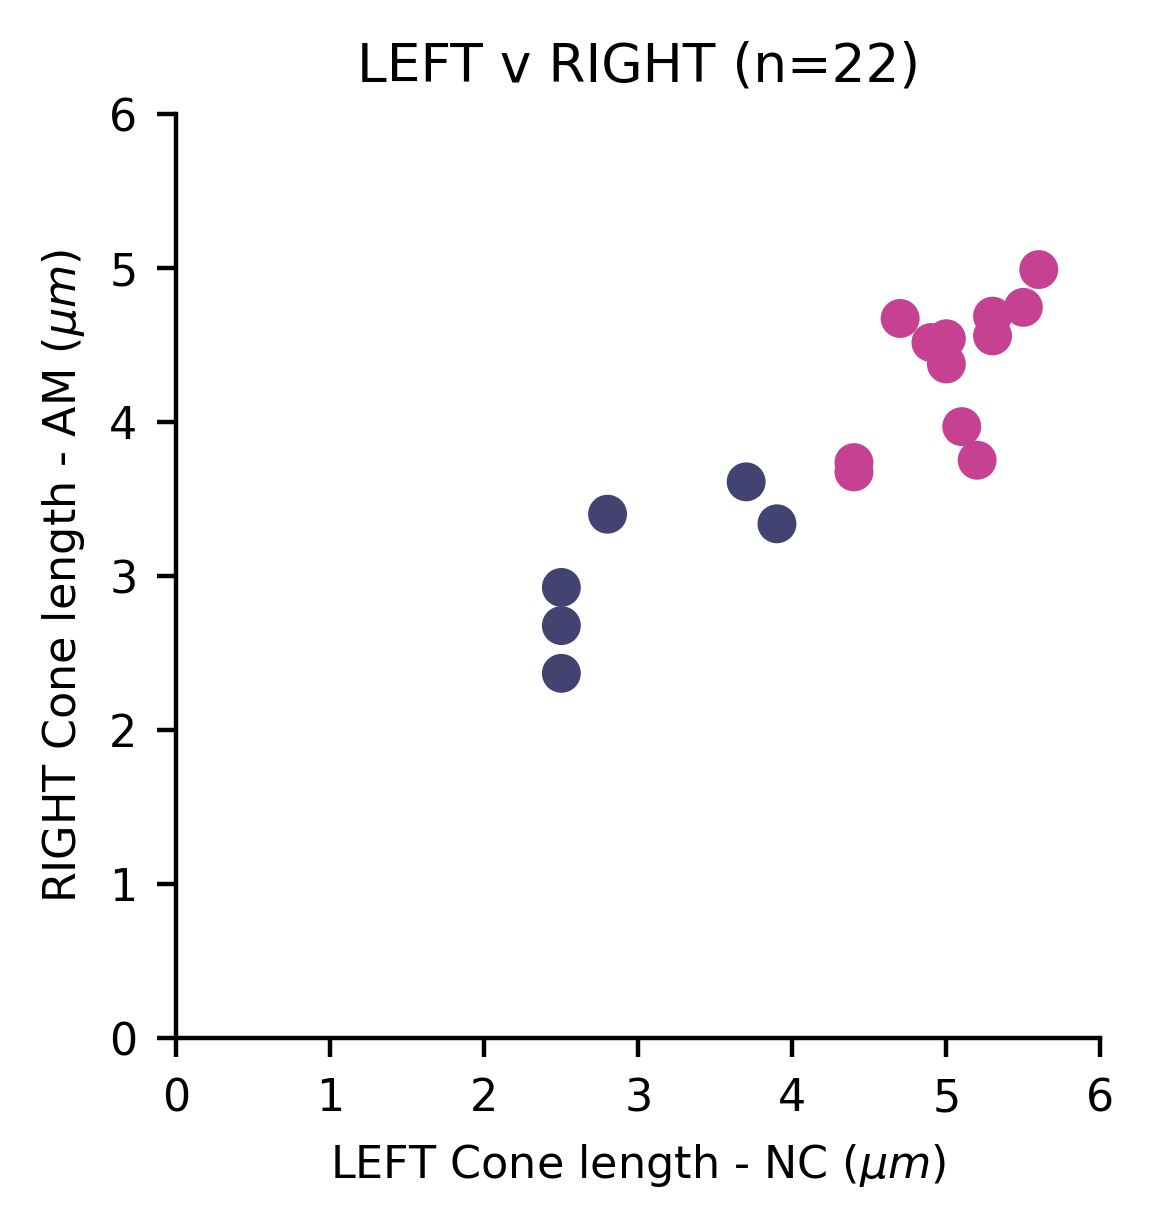

In [23]:
fig, ax = plt.subplots(1, figsize=[3, 3])

x = left_cc_len_in_r
y = am_right.loc[:, 'cone length (from the tip)']
assert(all([i == j for i, j in zip(x.index, y.index)]))
group_c = om_colors(am_right.index)
ax.scatter(x, y, c=group_c)
ax.set_xlim([0.0, 6.0])
ax.set_ylim([0.0, 6.0])
ax.set_xlabel(r"LEFT Cone length - NC ($\mu m$)")
ax.set_ylabel(r"RIGHT Cone length - AM ($\mu m$)")
ax.set_aspect('equal')
ax.set_title(f'LEFT v RIGHT (n={len(x)})')

print(f'Left variance: {left_cc_len.var(ddof=0)}')
print(f'Right variance: {y.var(ddof=0)}')

_x = x
X = sm.add_constant(_x)
Y = y

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())


In [24]:
def focal_length(r_outer: float, r_inner: float, thin_approx: bool=False, t: float=0.0) -> float:
    # For a bi convex lens, r_inner is negative
    r_inner = -1.0 * r_inner

    nl = 1.452 # lens
    nc = 1.348 # cone
    # lens power IN MICROMETERS
    p1 = (nl - 1.0)/r_outer # interface air->lens 
    p2 = (nc - nl)/r_inner # interface lens->cone
    
    if thin_approx:
        return 1.0/(p1 + p2)
    else:
        if t == 0.0:
            raise ValueError("t must be passed if thin_approx=False (the default option)")
        else:
            p3 = (t/nl) * p1 * p2
            return 1.0/(p1 + p2 -p3)


array([[1.     , 4.68667],
       [1.     , 5.05071],
       [1.     , 4.55839],
       [1.     , 4.73075],
       [1.     , 5.12575],
       [1.     , 4.9891 ],
       [1.     , 4.7437 ],
       [1.     , 4.34388],
       [1.     , 3.75099],
       [1.     , 4.67152],
       [1.     , 4.37625],
       [1.     , 4.53997],
       [1.     , 3.96908],
       [1.     , 3.61063],
       [1.     , 4.51521],
       [1.     , 3.67528],
       [1.     , 2.92506],
       [1.     , 2.36728],
       [1.     , 3.33824],
       [1.     , 3.73574],
       [1.     , 2.67703],
       [1.     , 3.40063]])

[8.483868306096333,
 7.739645669359032,
 8.589215305979543,
 7.979278350341788,
 7.674581655240491,
 8.18643412830124,
 8.576075506292002,
 8.631130751579464,
 7.255289464496847,
 6.954009270783231,
 8.266893609570445,
 8.35480972880079,
 7.888516054852764,
 5.797593790987819,
 6.717550452660889,
 6.176301296355163,
 3.736576599861004,
 4.69360434703236,
 7.623605838347478,
 4.632480866046885,
 4.339654641200654,
 3.456130104108229]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     30.95
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           1.91e-05
Time:                        18:15:08   Log-Likelihood:                -32.170
No. Observations:                  22   AIC:                             68.34
Df Residuals:                      20   BIC:                             70.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0286      1.257      0.023      0.982      -2.593       2.650
x1             1.6832      0.303      5.563      0.000       1.052       2.314
==============================================================================
Omnibus:                        0.513   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.774   Jarque-Bera (JB):                0.605
Skew:                          -0.285   Prob(JB):                        0.739
Kurtosis:                       2.421   Cond. No.                         23.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

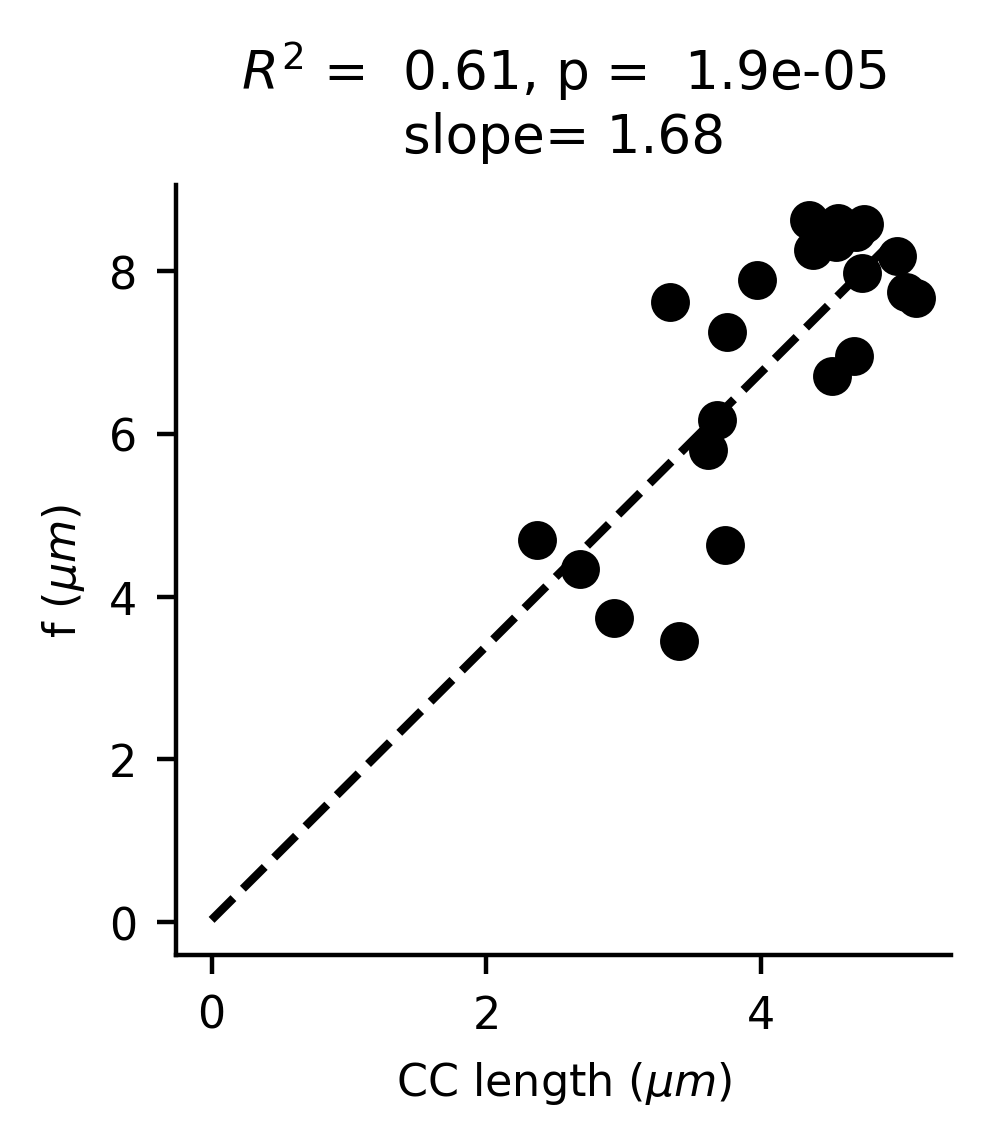

In [31]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

f_R = []
d_R = []
group_c = om_colors(am_right.index)
for om, row in am_right.iterrows():  # replace with am_df to include C6
    this_f = focal_length(r_outer=jp_right.loc[om, 'radii_out'], 
                          r_inner=jp_right.loc[om, 'radii_in'], 
                          #thin_approx=True)
                          t=jp_right.loc[om, 'lens_thickness'])
    
    f_R.append(this_f)
    d_R.append(row['cone length (from the tip)'])
    # ax.annotate(om, (row['cone length (from the tip)'], this_f))
    
_x = d_R
X = sm.add_constant(_x)
Y = f_R

display(X)
display(Y)

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

ax.scatter(x=_x, y=Y, marker='o', c='k')#c=group_c)
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax.set_xlabel("CC length ($\mu{m}$)")
ax.set_ylabel("f ($\mu{m}$)")

xx = np.arange(0, max(_x))
ax.plot(xx, params[1] * xx + params[0], c='k', ls='--')

if save_figs:
    fig.savefig(fig_path + 'focal-length-thick_cc-length_scatter.png')
    fig.savefig(fig_path + 'focal-length-thick_cc-length_scatter.svg')

## Correlation of focal length and distance between lens and rhabdom

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     9.530
Date:                Fri, 23 Jul 2021   Prob (F-statistic):            0.00464
Time:                        18:02:54   Log-Likelihood:                -49.493
No. Observations:                  29   AIC:                             103.0
Df Residuals:                      27   BIC:                             105.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4893      0.865      4.034      0.000       1.714       5.264
x1             0.5755      0.186      3.087      0.005       0.193       0.958
==============================================================================
Omnibus:                        3.212   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                1.411
Skew:                          -0.031   Prob(JB):                        0.494
Kurtosis:                       1.921   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[1.     , 4.68667],
       [1.     , 5.05071],
       [1.     , 4.55839],
       [1.     , 4.73075],
       [1.     , 5.12575],
       [1.     , 4.9891 ],
       [1.     , 4.7437 ],
       [1.     , 4.34388],
       [1.     , 3.75099],
       [1.     , 4.67152],
       [1.     , 4.37625],
       [1.     , 4.53997],
       [1.     , 3.96908],
       [1.     , 3.61063],
       [1.     , 4.51521],
       [1.     , 3.67528],
       [1.     , 2.92506],
       [1.     , 2.36728],
       [1.     , 3.33824],
       [1.     , 3.73574],
       [1.     , 2.67703],
       [1.     , 3.40063]])

[8.483868306096333,
 7.739645669359032,
 8.589215305979543,
 7.979278350341788,
 7.674581655240491,
 8.18643412830124,
 8.576075506292002,
 8.631130751579464,
 7.255289464496847,
 6.954009270783231,
 8.266893609570445,
 8.35480972880079,
 7.888516054852764,
 5.797593790987819,
 6.717550452660889,
 6.176301296355163,
 3.736576599861004,
 4.69360434703236,
 7.623605838347478,
 4.632480866046885,
 4.339654641200654,
 3.456130104108229]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     30.95
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           1.91e-05
Time:                        18:02:54   Log-Likelihood:                -32.170
No. Observations:                  22   AIC:                             68.34
Df Residuals:                      20   BIC:                             70.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0286      1.257      0.023      0.982      -2.593       2.650
x1             1.6832      0.303      5.563      0.000       1.052       2.314
==============================================================================
Omnibus:                        0.513   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.774   Jarque-Bera (JB):                0.605
Skew:                          -0.285   Prob(JB):                        0.739
Kurtosis:                       2.421   Cond. No.                         23.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     16.83
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           0.000154
Time:                        18:02:54   Log-Likelihood:                -90.605
No. Observations:                  51   AIC:                             185.2
Df Residuals:                      49   BIC:                             189.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3392      0.776      4.304      0.000       1.780       4.898
x1             0.7174      0.175      4.102      0.000       0.366       1.069
==============================================================================
Omnibus:                        7.364   Durbin-Watson:                   1.420
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                3.010
Skew:                          -0.286   Prob(JB):                        0.222
Kurtosis:                       1.956   Cond. No.                         17.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

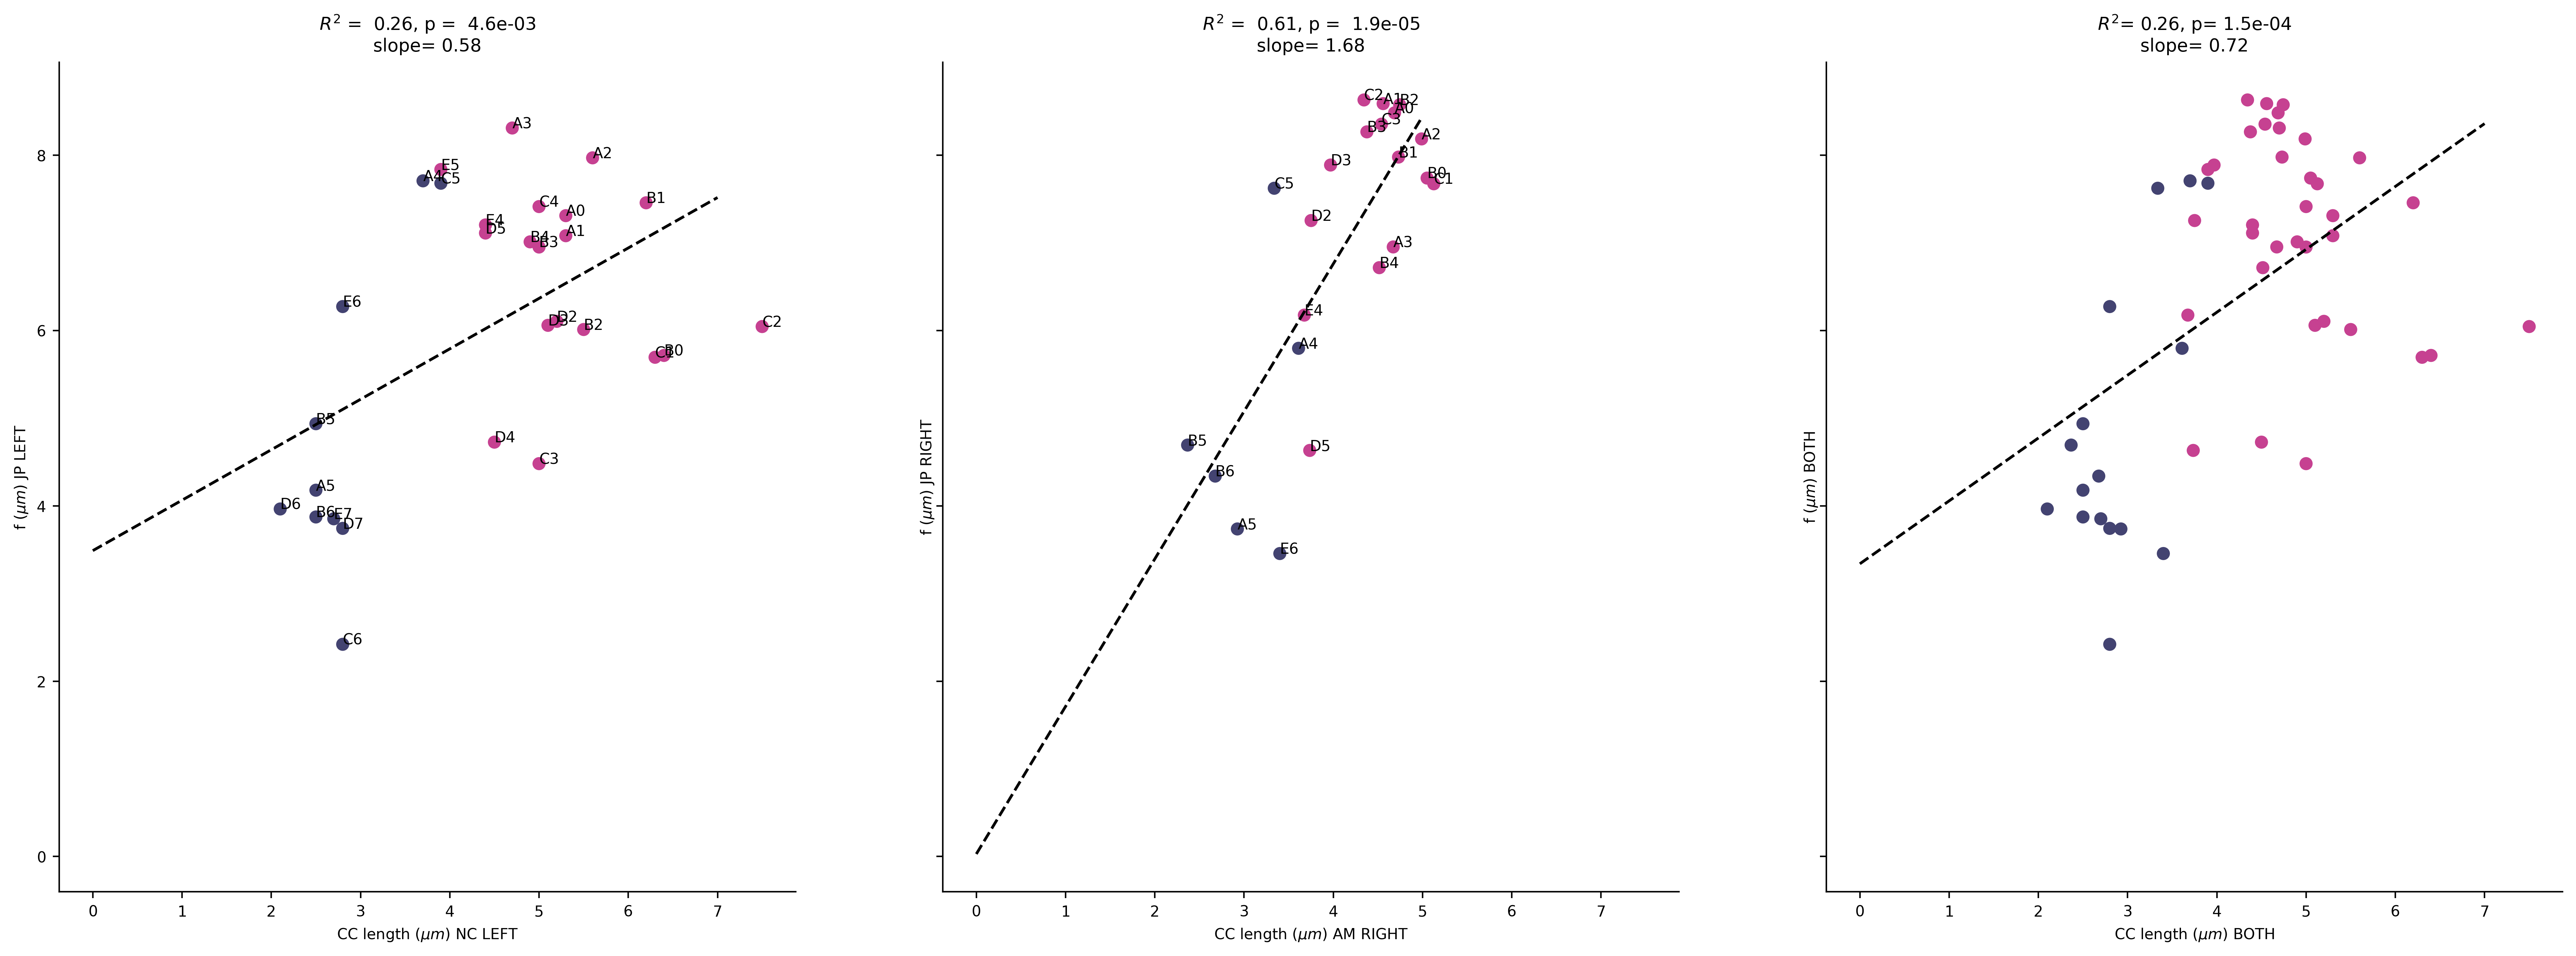

In [76]:
fig, ax = plt.subplots(1, 3, figsize=[24, 8], sharex=True, sharey=True)
# ~~~~~~~~~~ LEFT ~~~~~~~~~~~~
f_L = []
d_L = []
group_c = om_colors(jp_left.index)
for om, row in jp_left.iterrows():  # replace with am_df to include C6
    
    this_f = focal_length(row['radii_out'], 
                          row['radii_in'], 
                          t=row['lens_thickness'])
    
    f_L.append(this_f)
    d_L.append(cc_left[om])
    ax[0].annotate(om, (cc_left[om], this_f))
    
jp_left['f'] = f_L

_x = d_L
X = sm.add_constant(_x)
Y = f_L

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

ax[0].scatter(x=_x, y=Y, marker='o', c=group_c)
ax[0].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[0].set_xlabel('CC length ($\mu{m}$) NC LEFT')
ax[0].set_ylabel("f ($\mu{m}$) JP LEFT")

xx = np.arange(0, max(_x))
ax[0].plot(xx, params[1] * xx + params[0], c='k', ls='--')


# ~~~~~~~~~~ RIGHT ~~~~~~~~~~~~
f_R = []
d_R = []
group_c = om_colors(am_right.index)
for om, row in am_right.iterrows():  # replace with am_df to include C6
    
    this_f = focal_length(jp_right.loc[om, 'radii_out'], 
                          jp_right.loc[om, 'radii_in'], 
                          t=jp_right.loc[om, 'lens_thickness'])
    
    f_R.append(this_f)
    d_R.append(row['cone length (from the tip)'])
    ax[1].annotate(om, (row['cone length (from the tip)'], this_f))
    
jp_right['f'] = f_R
    
_x = d_R
X = sm.add_constant(_x)
Y = f_R

display(X)
display(Y)

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

ax[1].scatter(x=_x, y=Y, marker='o', c=group_c)
ax[1].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[1].set_xlabel('CC length ($\mu{m}$) AM RIGHT')
ax[1].set_ylabel("f ($\mu{m}$) JP RIGHT")

xx = np.arange(0, max(_x))
ax[1].plot(xx, params[1] * xx + params[0], c='k', ls='--')

# ~~~~~~~~~~ JP LEFT ~~~~~~~~~~~~
f_both = [*f_L, *f_R]
d_both = [*d_L, *d_R]
group_c = [*om_colors(jp_left.index), *om_colors(jp_right.index)]

_x = d_both
X = sm.add_constant(_x)
Y = f_both

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

ax[2].scatter(x=_x, y=Y, marker='o', c=group_c)
#ax[1].annotate(jp_right.index, (_x, Y))
ax[2].set_title(f'$R^{2}$={results.rsquared: .2f}, p={results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[2].set_xlabel('CC length ($\mu{m}$) BOTH')
ax[2].set_ylabel("f ($\mu{m}$) BOTH")

xx = np.arange(0, max(_x))
ax[2].plot(xx, params[1] * xx + params[0], c='k', ls='--')

## Focal length with respect to the position of rhabdom boundary

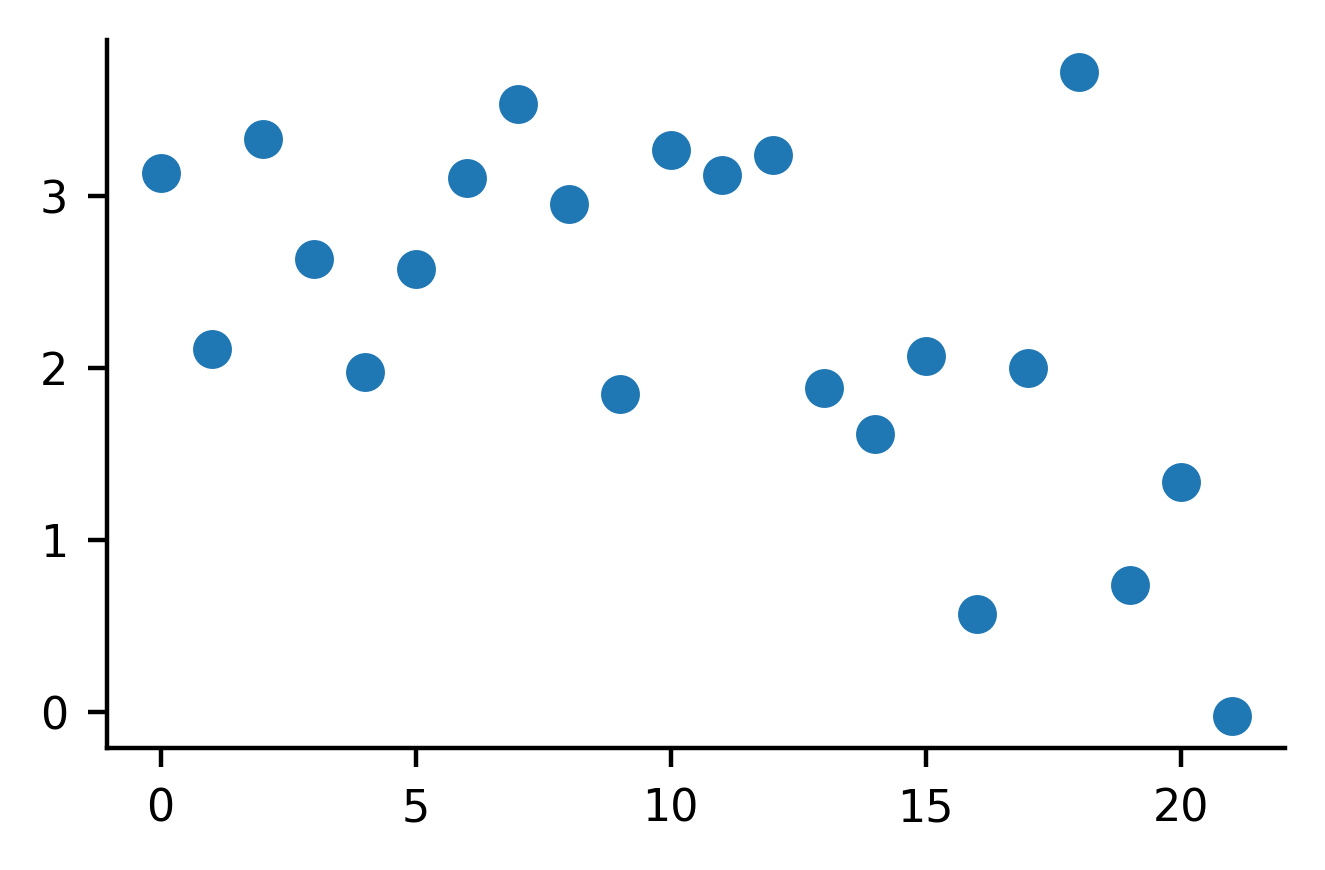

In [51]:
fig, ax = plt.subplots(1)

ax.scatter(y=jp_right['f'] - am_right['cone length (from the tip)'], x=np.arange(0, len(jp_right)))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     8.978
Date:                Thu, 01 Jul 2021   Prob (F-statistic):            0.00580
Time:                        16:46:14   Log-Likelihood:                -47.484
No. Observations:                  29   AIC:                             98.97
Df Residuals:                      27   BIC:                             101.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2361      0.911      3.550      0.001       1.366       5.106
x1             0.6238      0.208      2.996      0.006       0.197       1.051
==============================================================================
Omnibus:                        1.855   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.395   Jarque-Bera (JB):                1.085
Skew:                          -0.001   Prob(JB):                        0.581
Kurtosis:                       2.052   Cond. No.                         17.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     35.33
Date:                Thu, 01 Jul 2021   Prob (F-statistic):           8.19e-06
Time:                        16:46:14   Log-Likelihood:                -29.013
No. Observations:                  22   AIC:                             62.03
Df Residuals:                      20   BIC:                             64.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2179      1.089      0.200      0.843      -2.053       2.489
x1             1.5581      0.262      5.944      0.000       1.011       2.105
==============================================================================
Omnibus:                        0.236   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.429
Skew:                          -0.107   Prob(JB):                        0.807
Kurtosis:                       2.351   Cond. No.                         23.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     21.98
Date:                Thu, 01 Jul 2021   Prob (F-statistic):           2.23e-05
Time:                        16:46:14   Log-Likelihood:                -83.838
No. Observations:                  51   AIC:                             171.7
Df Residuals:                      49   BIC:                             175.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7087      0.761      3.560      0.001       1.180       4.238
x1             0.8328      0.178      4.688      0.000       0.476       1.190
==============================================================================
Omnibus:                        5.971   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                2.481
Skew:                          -0.199   Prob(JB):                        0.289
Kurtosis:                       1.996   Cond. No.                         19.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

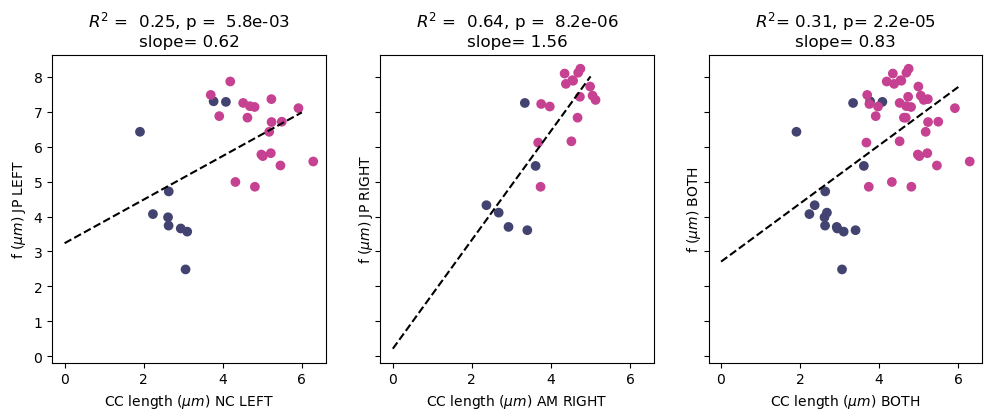

In [43]:
fig, ax = plt.subplots(1, 3, figsize=[12, 4], sharex=True, sharey=True)
# ~~~~~~~~~~ LEFT ~~~~~~~~~~~~
f_L = []
d_L = []
group_c = om_colors(jp_left.index)
for om, row in jp_left.iterrows():  # replace with am_df to include C6
    this_f = f_thick(row['radii_out'], row['radii_in'], row['lens_thickness'])
    f_L.append(this_f)
    d_L.append(row['distances'])
    #ax[0].annotate(om, (cc_left[om], this_f))
    
_x = d_L
X = sm.add_constant(_x)
Y = f_L

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

ax[0].scatter(x=_x, y=Y, marker='o', c=group_c)
ax[0].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[0].set_xlabel('CC length ($\mu{m}$) NC LEFT')
ax[0].set_ylabel("f ($\mu{m}$) JP LEFT")

xx = np.arange(0, max(_x))
ax[0].plot(xx, params[1] * xx + params[0], c='k', ls='--')


# ~~~~~~~~~~ RIGHT ~~~~~~~~~~~~
f_R = []
d_R = []
group_c = om_colors(am_right.index)
for om, row in am_right.iterrows():  # replace with am_df to include C6
    this_f = f_thick(jp_right.loc[om, 'radii_out'], jp_right.loc[om, 'radii_in'], jp_right.loc[om, 'lens_thickness'])
    f_R.append(this_f)
    d_R.append(row['cone length (from the tip)'])
    #ax[1].annotate(om, (row['cone length (from the tip)'], this_f))
    
_x = d_R
X = sm.add_constant(_x)
Y = f_R

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

ax[1].scatter(x=_x, y=Y, marker='o', c=group_c)
ax[1].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[1].set_xlabel('CC length ($\mu{m}$) AM RIGHT')
ax[1].set_ylabel("f ($\mu{m}$) JP RIGHT")

xx = np.arange(0, max(_x))
ax[1].plot(xx, params[1] * xx + params[0], c='k', ls='--')

# ~~~~~~~~~~ JP LEFT ~~~~~~~~~~~~
f_both = [*f_L, *f_R]
d_both = [*d_L, *d_R]
group_c = [*om_colors(jp_left.index), *om_colors(jp_right.index)]

_x = d_both
X = sm.add_constant(_x)
Y = f_both

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

ax[2].scatter(x=_x, y=Y, marker='o', c=group_c)
#ax[1].annotate(jp_right.index, (_x, Y))
ax[2].set_title(f'$R^{2}$={results.rsquared: .2f}, p={results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[2].set_xlabel('CC length ($\mu{m}$) BOTH')
ax[2].set_ylabel("f ($\mu{m}$) BOTH")

xx = np.arange(0, max(_x))
ax[2].plot(xx, params[1] * xx + params[0], c='k', ls='--')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     13.53
Date:                Thu, 01 Jul 2021   Prob (F-statistic):            0.00149
Time:                        16:33:04   Log-Likelihood:                -41.657
No. Observations:                  22   AIC:                             87.31
Df Residuals:                      20   BIC:                             89.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1509      1.934      3.697      0.001       3.116      11.186
x1             1.7128      0.466      3.678      0.001       0.741       2.684
==============================================================================
Omnibus:                        0.682   Durbin-Watson:                   1.219
Prob(Omnibus):                  0.711   Jarque-Bera (JB):                0.103
Skew:                           0.153   Prob(JB):                        0.950
Kurtosis:                       3.137   Cond. No.                         23.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[7.15091925 1.71278566]


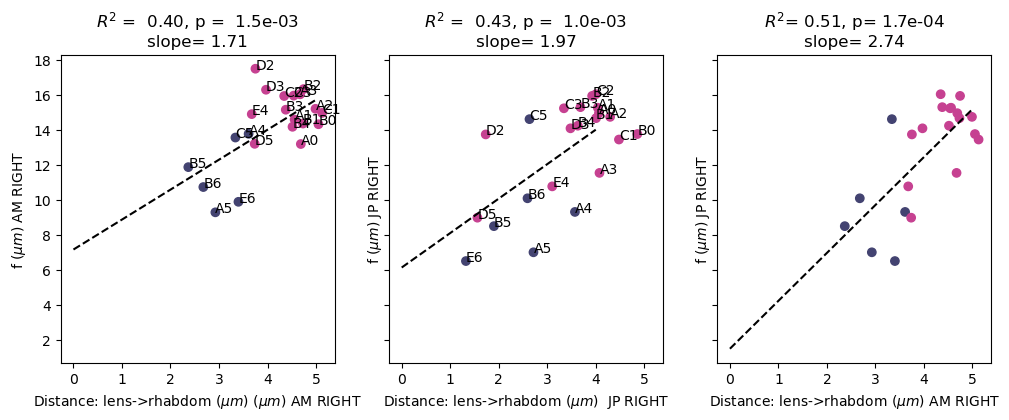

In [36]:


fig, ax = plt.subplots(1, 3, figsize=[12, 4], sharex=True, sharey=True)

n = 1.452 # Refraction index of Apis lens 
f_thin = lambda r_outer: r_outer * n / (n-1)

# THICK LENS #

# ~~~~~~~~~~ AM RIGHT ~~~~~~~~~~~~
f = []
d = []
group_c = om_colors(am_right.index)
for om, row in am_right.iterrows():  # replace with am_df to include C6
    f.append(f_thin(row['outer curvature']))
    d.append(row['cone length (from the tip)'])
    ax[0].annotate(om, (row['cone length (from the tip)'], f_thin(row['outer curvature'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())
print(params)

ax[0].scatter(x=_x, y=Y, marker='o', c=group_c)
ax[0].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[0].set_xlabel('Distance: lens->rhabdom ($\mu{m}$) ($\mu{m}$) AM RIGHT')
ax[0].set_ylabel("f ($\mu{m}$) AM RIGHT")

xx = np.arange(0, max(_x))
ax[0].plot(xx, params[1] * xx + params[0], c='k', ls='--')

# ~~~~~~~~~~ JP RIGHT ~~~~~~~~~~~~
f = []
d = []
group_c = om_colors(jp_right.index)
for om, row in jp_right.iterrows():  # replace with am_df to include C6
    f.append(f_thin(row['radii_out']))
    d.append(row['distances'])
    ax[1].annotate(om, (row['distances'], f_thin(row['radii_out'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax[1].scatter(x=_x, y=Y, marker='o', c=group_c)
#ax[1].annotate(jp_right.index, (_x, Y))
ax[1].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[1].set_xlabel('Distance: lens->rhabdom ($\mu{m}$)  JP RIGHT')
ax[1].set_ylabel("f ($\mu{m}$) JP RIGHT")

xx = np.arange(0, max(_x))
ax[1].plot(xx, params[1] * xx + params[0], c='k', ls='--')

# ~~~~~~~~~~ JP LEFT ~~~~~~~~~~~~
f = []
d = []
group_c = om_colors(jp_right.index)
for om, row in jp_right.iterrows():  # replace with am_df to include C6
    f.append(f_thin(row['radii_out']))
for om, row in am_right.iterrows():
    d.append(row['cone length (from the tip)'])
    #ax[2].annotate(om, (row['distances'], f_thin(row['radii_out'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax[2].scatter(x=_x, y=Y, marker='o', c=group_c)
#ax[1].annotate(jp_right.index, (_x, Y))
ax[2].set_title(f'$R^{2}$={results.rsquared: .2f}, p={results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[2].set_xlabel('Distance: lens->rhabdom ($\mu{m}$) AM RIGHT')
ax[2].set_ylabel("f ($\mu{m}$) JP RIGHT")

xx = np.arange(0, max(_x))
ax[2].plot(xx, params[1] * xx + params[0], c='k', ls='--')


Text(0, 0.5, 'f (thick eq) JP RIGHT')

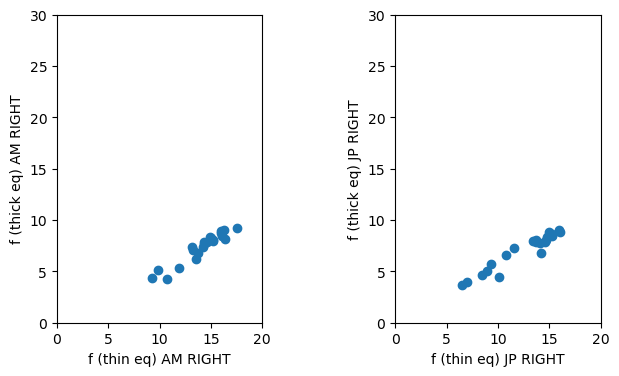

In [27]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4],)

x = f_thin(am_right['outer curvature'])
y = [f_thick(o, i, t) for o, i, t in zip(am_right['outer curvature'], am_right['inner curvature'], am_right['lense thickness'])]
labels = [str(i) for i in am_right.index]

ax[0].scatter(x, y)
#ax[0].annotate(labels, (x, y))

ax[0].set_aspect('equal')
ax[0].set_xlim([0, 20])
ax[0].set_ylim([0, 30])
ax[0].set_xlabel('f (thin eq) AM RIGHT')
ax[0].set_ylabel('f (thick eq) AM RIGHT')


x = f_thin(jp_right['radii_out'])
y = [f_thick(o, i, t) for o, i, t in zip(jp_right['radii_out'], jp_right['radii_in'], jp_right['lens_thickness'])]
labels = [str(i) for i in jp_right.index]

ax[1].scatter(x, y)
#ax[1].annotate(labels, (x, y))

ax[1].set_aspect('equal')
ax[1].set_xlim([0, 20])
ax[1].set_ylim([0, 30])
ax[1].set_xlabel('f (thin eq) JP RIGHT')
ax[1].set_ylabel('f (thick eq) JP RIGHT')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     35.33
Date:                Thu, 01 Jul 2021   Prob (F-statistic):           8.19e-06
Time:                        16:36:28   Log-Likelihood:                -29.013
No. Observations:                  22   AIC:                             62.03
Df Residuals:                      20   BIC:                             64.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2179      1.089      0.200      0.843      -2.053       2.489
x1             1.5581      0.262      5.944      0.000       1.011       2.105
==============================================================================
Omnibus:                        0.236   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.429
Skew:                          -0.107   Prob(JB):                        0.807
Kurtosis:                       2.351   Cond. No.                         23.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

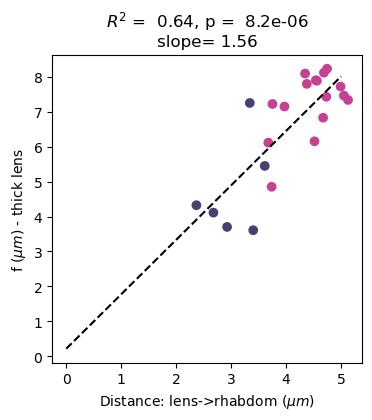

In [37]:
fig, ax = plt.subplots(1, figsize=[4, 4], sharex=True, sharey=True)

f = [f_thick(o, i, t) for o, i, t in zip(jp_right['radii_out'], jp_right['radii_in'], jp_right['lens_thickness'])]
d = [am_right.loc[om, 'cone length (from the tip)'] for om in jp_right.index]
region_c = om_colors(jp_right.index)
region_m = om_markers(jp_right.index)

_x = d
X = sm.add_constant(_x)
Y = f

# REGRESSION
model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

ax.scatter(x=_x, y=Y, color=region_c)
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax.set_xlabel('Distance: lens->rhabdom ($\mu{m}$)')
ax.set_ylabel("f ($\mu{m}$) - thick lens")

xx = np.arange(0, max(_x))
ax.plot(xx, params[1] * xx + params[0], c='k', ls='--')